In [1]:
from behav import find_logfile, get_VTC_from_file, plot_VTC, SDT
import os
from saflow_params import BLOCS_LIST, SUBJ_LIST
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import pandas as pd
import seaborn as sns
from itertools import product


In [2]:
def count_trials(logs_data, trials_list):
    correct_comission = 0
    correct_omission = 0
    error_comission = 0
    error_omission = 0
    responses = [52,55]
    for trial in trials_list:
        if logs_data[trial][0] == 1: 
            if logs_data[trial][1] not in responses: # if an upcoming rare has no response
                correct_omission += 1
            else:
                error_comission += 1
        if logs_data[trial][0] == 2:
            if logs_data[trial][1] in responses:
                correct_comission += 1
            else:
                error_omission += 1  
    return correct_omission, correct_comission, error_comission, error_omission

def compute_all_SDT(log_files, SUBJ_LIST, BLOCS_LIST, metric='d', lobound=None, hibound=None, filt=True, filt_order=3, filt_cutoff=0.05):
    Ds_IN = []
    Ds_OUT = []
    for SUBJ in SUBJ_LIST:
        subj_IN = []
        subj_OUT = []
        for BLOC in BLOCS_LIST:
            logfile = find_logfile(SUBJ, BLOC, log_files)
            logs = loadmat(log_dir + logfile)
            # obtain VTC
            VTC, INbounds, OUTbounds, INzone, OUTzone = get_VTC_from_file(log_dir + logfile, lobound=lobound, hibound=hibound, filt=filt, filt_order=filt_order, filt_cutoff=filt_cutoff)
            # count errors and successes
            IN_co, IN_cc, IN_ec, IN_eo = count_trials(logs['response'], INzone)
            OUT_co, OUT_cc, OUT_ec, OUT_eo = count_trials(logs['response'], OUTzone)
            # compute SDT metrics
            IN_SDT = SDT(IN_co, IN_ec, IN_eo, IN_cc)
            OUT_SDT = SDT(OUT_co, OUT_ec, OUT_eo, OUT_cc)
            subj_IN.append(IN_SDT[metric])
            subj_OUT.append(OUT_SDT[metric])
        Ds_IN.append(np.mean(subj_IN))
        Ds_OUT.append(np.mean(subj_OUT))
    Ds_IN = np.array(Ds_IN)
    Ds_OUT = np.array(Ds_OUT)
    return Ds_IN, Ds_OUT
        
    
def plot_SDT_metric(Ds_IN, Ds_OUT, savefig=False, savepath=None, metric='d', lobound=None, hibound=None, pval=None, show=False):
    # your input data:
    befores = np.array(Ds_IN)
    afters = np.array(Ds_OUT)

    # plotting the points
    plt.scatter(np.zeros(len(befores)), befores)
    plt.scatter(np.ones(len(afters)), afters)

    # plotting the lines
    for i in range(len(befores)):
        plt.plot([0,1], [befores[i], afters[i]], c='k')

    plt.xticks([0,1], ['IN', 'OUT'])
    if lobound != None and hibound != None:
        title = '{}_IN{}OUT{}_p{}'.format(metric, int(lobound*100), int(hibound*100), round(pval, 5))
    else:
        title = '{}_INOUT_p{}'.format(metric, round(pval, 5))
    plt.title(title)
    if savefig == True:
        plt.savefig(savepath + title + '.png')
    if show == True:
        plt.show()
    else:
        plt.close()

In [3]:
# Params
SAVEPATH = '/home/hyruuk/pCloudDrive/science/saflow/images/behav/'
LOG_DIR = '/home/hyruuk/pCloudDrive/science/saflow/gradCPT/gradCPT_share_Mac_PC/gradCPT_share_Mac_PC/saflow_data/'
bounds = [(None,None), (0.40,0.60), (0.25,0.75), (0.15,0.85)]
metrics = ['c', 'd', 'beta', 'Ad']
alpha = 0.05
filt_order = 3
filt_cutoff = 0.1
savefig = False
forders = [2,3,4]
fcutoffs = [0.01,0.05,0.1]
f_params = [i for i in product(fcutoffs,forders)]

In [ ]:
for met_idx, metric in enumerate(metrics):
    matrix = np.zeros((len(f_params), len(bounds)))
    mask = np.zeros((len(f_params), len(bounds)))
    for f_par_idx, f_param in enumerate(f_params):
        for bound_idx, bound in enumerate(bounds):
            lobound=bound[0]
            hibound=bound[1]
            filt_order = f_param[1]
            filt_cutoff = f_param[0]
            log_files = os.listdir(LOG_DIR)
            Ds_IN, Ds_OUT = compute_all_SDT(log_files, SUBJ_LIST, BLOCS_LIST, 
                                            metric=metric, lobound=lobound, hibound=hibound, 
                                            filt=True, filt_order=filt_order, filt_cutoff=filt_cutoff)
            tval, pval = ttest_rel(Ds_IN, Ds_OUT)
            print('Computed {}{} split with fparams {}{} : tval = {}, pval = {}'.format(bound, metric,filt_order, filt_cutoff, tval, pval))
            plot_SDT_metric(Ds_IN, Ds_OUT, show=False, savefig=savefig, savepath=SAVEPATH, 
                            metric=metric, lobound=lobound, hibound=hibound, pval=pval)
            # create matrix for results plotting
            matrix[f_par_idx,bound_idx] = tval
            if pval >= alpha:
                mask[f_par_idx,bound_idx] = 1
    # create and save plot
    plt.figure(figsize=(10,7))
    ax = sns.heatmap(matrix, mask=mask, linewidths=.1, annot=True, xticklabels=bounds, yticklabels=f_params)
    plt.title(metric)
    plt.xlabel('Bounds (IN, OUT)')
    plt.ylabel('Filter (Order, Cutoff)')
    plt.savefig(SAVEPATH + '{}_tvals_a05.png'.format(metric))
    plt.close()


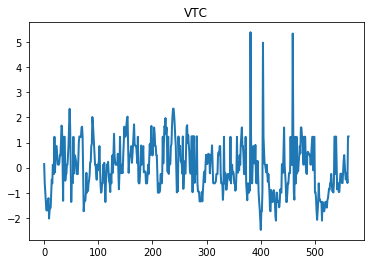

In [14]:
SUBJ = '06'
BLOC = '7'

filt = False
lobound=None
hibound=None

log_files = os.listdir(LOG_DIR)
logfile = find_logfile(SUBJ, BLOC, log_files)
logfilepath = LOG_DIR + logfile
logs = loadmat(logfilepath)
# obtain VTC
VTC, INbounds, OUTbounds, INzone, OUTzone = get_VTC_from_file(logfilepath, lobound=lobound, hibound=hibound, filt=filt, filt_order=filt_order, filt_cutoff=filt_cutoff)
savefile = SAVEPATH + 'rawVTC_s{}_b{}.png'.format(SUBJ, BLOC)
plot_VTC(VTC, figpath = savefile, save=True, INOUT=False)

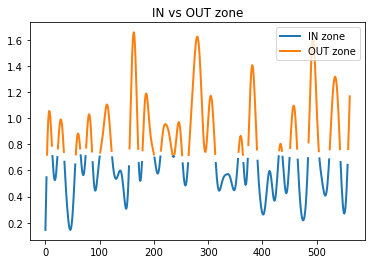

In [33]:
SUBJ = '05'
BLOC = '7'

filt = True
lobound=None
hibound=None
filt_order = 4
filt_cutoff = 0.1

log_files = os.listdir(LOG_DIR)
logfile = find_logfile(SUBJ, BLOC, log_files)
logfilepath = LOG_DIR + logfile
logs = loadmat(logfilepath)
# obtain VTC
VTC, INbounds, OUTbounds, INzone, OUTzone = get_VTC_from_file(logfilepath, lobound=lobound, hibound=hibound, filt=filt, filt_order=filt_order, filt_cutoff=filt_cutoff)
savefile = SAVEPATH + 'filtVTC_s{}_b{}_o{}_c{}.png'.format(SUBJ, BLOC, filt_order, filt_cutoff)
plot_VTC(VTC, figpath = savefile, save=True, INOUT=True)